<a href="https://colab.research.google.com/github/bravoeight98/_CSE-445_Project/blob/main/BFND_SVMClassifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imporing Packages and Libraries

Importing all necessary packages

In [1]:
#import package

!pip install ipython-autotime
%load_ext autotime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
time: 663 ms (started: 2021-09-06 10:21:32 +00:00)


# Getting and preparing Datasets

Mount from Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 4.29 ms (started: 2021-09-06 10:21:37 +00:00)


Check the dataset files

In [3]:
# Reading from file 
fake = pd.read_csv('/content/drive/MyDrive/BanFakeNewsDataset/Fake-1K.csv')
true = pd.read_csv('/content/drive/MyDrive/BanFakeNewsDataset/Authentic-48K.csv')

time: 2.97 s (started: 2021-09-06 10:21:40 +00:00)


Show Info

In [4]:
print(true.shape)
print(true.info())
true.head()

(48678, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48678 entries, 0 to 48677
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   articleID  48678 non-null  int64 
 1   domain     48678 non-null  object
 2   date       48678 non-null  object
 3   category   48678 non-null  object
 4   headline   48678 non-null  object
 5   content    48678 non-null  object
 6   label      48678 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 2.6+ MB
None


,articleID,domain,date,category,headline,content,label
0,1,jagonews24.com,2018-09-19 17:48:18,Education,"হট্টগোল করায় বাকৃবিতে দুইজন বরখাস্ত, ৬ জনকে শোকজ",গত ১৭ সেপ্টেম্বর বাংলাদেশ কৃষি বিশ্ববিদ্যালয়ে ...,1
1,2,jagonews24.com,2018-09-19 17:48:19,National,মালয়েশিয়ায় কর্মী পাঠানোর ব্যবস্থা নেয়ার সুপারিশ,বাংলাদেশের বৃহৎ শ্রমবাজার মালয়েশিয়ায় আবার শ্রম...,1
2,3,jagonews24.com,2018-09-19 17:48:20,National,প্রেমের প্রস্তাবে রাজি না হওয়ায় স্কুলছাত্রীকে ...,নরসিংদীর মনোহরদীতে প্রেমের প্রস্তাবে রাজি না হ...,1
3,4,jagonews24.com,2018-09-19 17:48:21,Crime,মেডিয়েশনই মামলাজট নিরসনের পথ : বিচারপতি আহমেদ ...,সুপ্রিম কোর্টের হাইকোর্ট বিভাগের বিচারপতি আহমে...,1
4,5,jagonews24.com,2018-09-19 17:48:21,National,টকশোতে বক্তব্য দিতে গিয়ে জাপা নেতার মৃত্যু,মাদারীপুর সদরের উপজেলার লেকেরপাড়ে একটি বেসরকার...,1


time: 47.4 ms (started: 2021-09-06 10:21:55 +00:00)


In [5]:
print(fake.shape)
print(fake.info())
fake.head()

(1299, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1299 entries, 0 to 1298
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   articleID  1299 non-null   int64 
 1   domain     1299 non-null   object
 2   date       1299 non-null   object
 3   category   1299 non-null   object
 4   headline   1299 non-null   object
 5   content    1299 non-null   object
 6   label      1299 non-null   int64 
dtypes: int64(2), object(5)
memory usage: 71.2+ KB
None


,articleID,domain,date,category,headline,content,label
0,1,channeldhaka.news,2019-03-14T13:34:14+00:00,International,মুরগির হামলায় শেয়াল নিহত,"বাংলায় একটা প্রবাদ আছে, শেয়ালের কাছে মুরগী বর্...",0
1,2,earki.com,"সেম্বর ১৭, ২০১৮",Miscellaneous,বিটিভিতে যেবার আমি ইন্টারভিউ দিতে গেলাম,"BTV থেকে লোকজন আসছে, ইন্টারভিউ নিবে।চারজনের টি...",0
2,3,earki.com,"২০:৩৯, জানুয়ারি ১৪, ২০১৯",Miscellaneous,বিদেশ থেকে উন্নতমানের বিরোধীদল আমদানি করার পরা...,অদ্ভুত বিরোধীদলহীনতায় ভুগছে সরকার। এ এক অন্যরক...,0
3,4,channeldhaka.news,2018-06-30T15:56:47+00:00,Sports,অবসর নেয়ার ঘোষণা দিলেন মেসি !,রাশিয়া বিশ্বকাপ নকআউট পর্বে ফ্রান্সের সাথে ৪-৩...,0
4,5,motikontho.wordpress.com,2013-03-05T21:55:45+00:00,Miscellaneous,"মাদারফাকার নহে, ব্রাদারফাকার: সাকা | দৈনিক মতি...","নিজস্ব মতিবেদক‘মাদারফাকার নহে, আমি ব্রাদারফাকা...",0


time: 32.4 ms (started: 2021-09-06 10:21:59 +00:00)


# Preprocessing Data

In [6]:
fake['Label'] = 1
true['Label'] = 0

time: 2.33 ms (started: 2021-09-06 10:22:03 +00:00)


In [7]:
data = pd.concat([true,fake],axis=0,ignore_index=True)
print(data.shape)
data.head()

(49977, 8)


,articleID,domain,date,category,headline,content,label,Label
0,1,jagonews24.com,2018-09-19 17:48:18,Education,"হট্টগোল করায় বাকৃবিতে দুইজন বরখাস্ত, ৬ জনকে শোকজ",গত ১৭ সেপ্টেম্বর বাংলাদেশ কৃষি বিশ্ববিদ্যালয়ে ...,1,0
1,2,jagonews24.com,2018-09-19 17:48:19,National,মালয়েশিয়ায় কর্মী পাঠানোর ব্যবস্থা নেয়ার সুপারিশ,বাংলাদেশের বৃহৎ শ্রমবাজার মালয়েশিয়ায় আবার শ্রম...,1,0
2,3,jagonews24.com,2018-09-19 17:48:20,National,প্রেমের প্রস্তাবে রাজি না হওয়ায় স্কুলছাত্রীকে ...,নরসিংদীর মনোহরদীতে প্রেমের প্রস্তাবে রাজি না হ...,1,0
3,4,jagonews24.com,2018-09-19 17:48:21,Crime,মেডিয়েশনই মামলাজট নিরসনের পথ : বিচারপতি আহমেদ ...,সুপ্রিম কোর্টের হাইকোর্ট বিভাগের বিচারপতি আহমে...,1,0
4,5,jagonews24.com,2018-09-19 17:48:21,National,টকশোতে বক্তব্য দিতে গিয়ে জাপা নেতার মৃত্যু,মাদারীপুর সদরের উপজেলার লেকেরপাড়ে একটি বেসরকার...,1,0


time: 37.1 ms (started: 2021-09-06 10:22:04 +00:00)


In [8]:
data.describe()

,articleID,label,Label
count,49977.000000,49977.000000,49977.000000
mean,30045.527142,0.974008,0.025992
std,18317.000506,0.159113,0.159113
min,1.000000,0.000000,0.000000
25%,14168.000000,1.000000,0.000000
50%,30039.000000,1.000000,0.000000
75%,45898.000000,1.000000,0.000000
max,61780.000000,1.000000,1.000000


time: 29.7 ms (started: 2021-09-06 10:22:08 +00:00)


In [9]:
data['content']=data['headline']+data['content']
data=data.drop(['headline'], axis=1)

time: 104 ms (started: 2021-09-06 10:22:11 +00:00)


Chek if dataset is Balanced

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


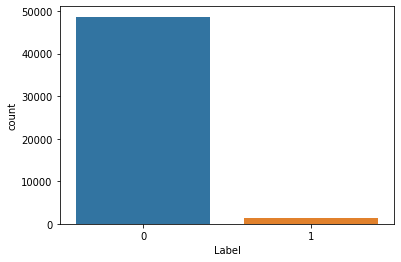

time: 148 ms (started: 2021-09-06 10:22:14 +00:00)


In [10]:
sns.countplot(data.Label)

Conclusion: Imbalanced Dataset

In [11]:
data.category.value_counts()

National         18807
International     7081
Sports            6580
Editorial         3504
Politics          3031
Miscellaneous     2872
Entertainment     2742
Finance           1226
Education         1145
Crime             1114
Lifestyle         1003
Technology         872
Name: category, dtype: int64

time: 14.7 ms (started: 2021-09-06 10:22:17 +00:00)


# Data Cleaning

Removing stop words in order to root words that are retaining in the data and fed into the models

In [12]:
#stop = stopwords.words('bangla')
stop = frozenset(["অবশ্য", "অনেক", "অনেকে", "অনেকেই", "অন্তত", "অথবা", "অথচ",
"অর্থাত",
"অন্য",
"আজ",
"আছে",
"আপনার",
"আপনি",
"আবার",
"আমরা",
"আমাকে",
"আমাদের",
"আমার",
"আমি",
"আরও",
"আর",
"আগে",
"আগেই",
"আই",
"অতএব",
"আগামী",
"অবধি",
"অনুযায়ী",
"আদ্যভাগে",
"এই",
"একই",
"একে",
"একটি",
"এখন",
"এখনও",
"এখানে",
"এখানেই",
"এটি",
"এটা",
"এটাই",
"এতটাই",
"এবং",
"একবার",
"এবার",
"এদের",
"এঁদের",
"এমন",
"এমনকী",
"এল",
"এর",
"এরা",
"এঁরা",
"এস",
"এত",
"এতে",
"এসে",
"একে",
"এ",
"ঐ",
"ই",
"ইহা",
"ইত্যাদি",
"উনি",
"উপর",
"উপরে",
"উচিত",
"ও",
"ওই",
"ওর",
"ওরা",
"ওঁর",
"ওঁরা",
"ওকে",
"ওদের",
"ওঁদের"
"ওখানে",
"কত",
"কবে",
"করতে",
"কয়েক",
"কয়েকটি",
"করবে",
"করলেন",
"করার",
"কারও",
"করা",
"করি",
"করিয়ে",
"করার",
"করাই",
"করলে",
"করলেন",
"করিতে",
"করিয়া",
"করেছিলেন",
"করছে",
"করছেন",
"করেছেন",
"করেছে",
"করেন",
"করবেন",
"করায়",
"করে",
"করেই",
"কাছ",
"কাছে",
"কাজে",
"কারণ",
"কিছু",
"কিছুই",
"কিন্তু",
"কিংবা",
"কি",
"কী",
"কেউ",
"কেউই",
"কাউকে",
"কেন",
"কে",
"কোনও",
"কোনো",
"কোন",
"কখনও",
"ক্ষেত্রে",
"খুব",	
"গুলি",
"গিয়ে",
"গিয়েছে",
"গেছে",
"গেল",
"গেলে",
"গোটা",
"চলে",
"ছাড়া",
"ছাড়াও",
"ছিলেন",
"ছিল",
"জন্য",
"জানা",
"ঠিক",
"তিনি",
"তিনঐ",
"তিনিও",
"তখন",
"তবে",
"তবু",
"তাঁদের",
"তাঁহারা",
"তাঁরা",
"তাঁর",
"তাঁকে",
"তাই",
"তেমন",
"তাকে",
"তাহা",
"তাহাতে",
"তাহার",
"তাদের",
"তারপর",
"তারা",
"তারৈ",
"তার",
"তাহলে",
"তিনি",
"তা",
"তাও",
"তাতে",
"তো",
"তত",
"তুমি",
"তোমার",
"তথা",
"থাকে",
"থাকা",
"থাকায়",
"থেকে",
"থেকেও",
"থাকবে",
"থাকেন",
"থাকবেন",
"থেকেই",
"দিকে",
"দিতে",
"দিয়ে",
"দিয়েছে",
"দিয়েছেন",
"দিলেন",
"দু",
"দুটি",
"দুটো",
"দেয়",
"দেওয়া",
"দেওয়ার",
"দেখা",
"দেখে",
"দেখতে",
"দ্বারা",
"ধরে",
"ধরা",
"নয়",
"নানা",
"না",
"নাকি",
"নাগাদ",
"নিতে",
"নিজে",
"নিজেই",
"নিজের",
"নিজেদের",
"নিয়ে",
"নেওয়া",
"নেওয়ার",
"নেই",
"নাই",
"পক্ষে",
"পর্যন্ত",
"পাওয়া",
"পারেন",
"পারি",
"পারে",
"পরে",
"পরেই",
"পরেও",
"পর",
"পেয়ে",
"প্রতি",
"প্রভৃতি",
"প্রায়",
"ফের",
"ফলে",
"ফিরে",
"ব্যবহার",
"বলতে",
"বললেন",
"বলেছেন",
"বলল",
"বলা",
"বলেন",
"বলে",
"বহু",
"বসে",
"বার",
"বা",
"বিনা",
"বরং",
"বদলে",
"বাদে",
"বার",
"বিশেষ",
"বিভিন্ন	বিষয়টি",
"ব্যবহার",
"ব্যাপারে",
"ভাবে",
"ভাবেই",
"মধ্যে",
"মধ্যেই",
"মধ্যেও",
"মধ্যভাগে",
"মাধ্যমে",
"মাত্র",
"মতো",
"মতোই",
"মোটেই",
"যখন",
"যদি",
"যদিও",
"যাবে",
"যায়",
"যাকে",
"যাওয়া",
"যাওয়ার",
"যত",
"যতটা",
"যা",
"যার",
"যারা",
"যাঁর",
"যাঁরা",
"যাদের",
"যান",
"যাচ্ছে",
"যেতে",
"যাতে",
"যেন",
"যেমন",
"যেখানে",
"যিনি",
"যে",
"রেখে",
"রাখা",
"রয়েছে",
"রকম",
"শুধু",
"সঙ্গে",
"সঙ্গেও",
"সমস্ত",
"সব",
"সবার",
"সহ",
"সুতরাং",
"সহিত",
"সেই",
"সেটা",
"সেটি",
"সেটাই",
"সেটাও",
"সম্প্রতি",
"সেখান",
"সেখানে",
"সে",
"স্পষ্ট",
"স্বয়ং",
"হইতে",
"হইবে",
"হৈলে",
"হইয়া",
"হচ্ছে",
"হত",
"হতে",
"হতেই",
"হবে",
"হবেন",
"হয়েছিল",
"হয়েছে",
"হয়েছেন",
"হয়ে",
"হয়নি",
"হয়",
"হয়েই",
"হয়তো",
"হল",
"হলে",
"হলেই",
"হলেও",
"হলো",
"হিসাবে",
"হওয়া",
"হওয়ার",
"হওয়ায়",
"হন",
"হোক",
"জন",
"জনকে",
"জনের",
"জানতে",
"জানায়",
"জানিয়ে",
"জানানো",
"জানিয়েছে",
"জন্য", "জন্যওজে", "জে", "বেশ", "দেন", "তুলে", "ছিলেন", "চান", "চায়", "চেয়ে", "মোট", "যথেষ্ট", "টি"])
data['content'] = data['content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

time: 3.96 s (started: 2021-09-06 10:22:20 +00:00)


Lemmatizing words int order to only root words are retain in the data and fed into the model

In [13]:
nltk.download('wordnet')
def lemmatize_words(content):
    wnl = nltk.stem.WordNetLemmatizer()
    lem = ' '.join([wnl.lemmatize(word) for word in content.split()])    
    return lem

data['content'] = data['content'].apply(lemmatize_words)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
time: 42.2 s (started: 2021-09-06 10:22:30 +00:00)


#Bulding Model

Spliting datas into training set and test set

In [14]:
y = data['Label']
X_train, X_test, y_train, y_test = train_test_split(data['content'], y,test_size=0.33,random_state=53)

time: 14.7 ms (started: 2021-09-06 10:23:18 +00:00)


In [15]:
count_vectorizer = CountVectorizer(stop_words = frozenset(["অবশ্য", "অনেক", "অনেকে", "অনেকেই", "অন্তত", "অথবা", "অথচ",
"অর্থাত",
"অন্য",
"আজ",
"আছে",
"আপনার",
"আপনি",
"আবার",
"আমরা",
"আমাকে",
"আমাদের",
"আমার",
"আমি",
"আরও",
"আর",
"আগে",
"আগেই",
"আই",
"অতএব",
"আগামী",
"অবধি",
"অনুযায়ী",
"আদ্যভাগে",
"এই",
"একই",
"একে",
"একটি",
"এখন",
"এখনও",
"এখানে",
"এখানেই",
"এটি",
"এটা",
"এটাই",
"এতটাই",
"এবং",
"একবার",
"এবার",
"এদের",
"এঁদের",
"এমন",
"এমনকী",
"এল",
"এর",
"এরা",
"এঁরা",
"এস",
"এত",
"এতে",
"এসে",
"একে",
"এ",
"ঐ",
"ই",
"ইহা",
"ইত্যাদি",
"উনি",
"উপর",
"উপরে",
"উচিত",
"ও",
"ওই",
"ওর",
"ওরা",
"ওঁর",
"ওঁরা",
"ওকে",
"ওদের",
"ওঁদের"
"ওখানে",
"কত",
"কবে",
"করতে",
"কয়েক",
"কয়েকটি",
"করবে",
"করলেন",
"করার",
"কারও",
"করা",
"করি",
"করিয়ে",
"করার",
"করাই",
"করলে",
"করলেন",
"করিতে",
"করিয়া",
"করেছিলেন",
"করছে",
"করছেন",
"করেছেন",
"করেছে",
"করেন",
"করবেন",
"করায়",
"করে",
"করেই",
"কাছ",
"কাছে",
"কাজে",
"কারণ",
"কিছু",
"কিছুই",
"কিন্তু",
"কিংবা",
"কি",
"কী",
"কেউ",
"কেউই",
"কাউকে",
"কেন",
"কে",
"কোনও",
"কোনো",
"কোন",
"কখনও",
"ক্ষেত্রে",
"খুব",	
"গুলি",
"গিয়ে",
"গিয়েছে",
"গেছে",
"গেল",
"গেলে",
"গোটা",
"চলে",
"ছাড়া",
"ছাড়াও",
"ছিলেন",
"ছিল",
"জন্য",
"জানা",
"ঠিক",
"তিনি",
"তিনঐ",
"তিনিও",
"তখন",
"তবে",
"তবু",
"তাঁদের",
"তাঁহারা",
"তাঁরা",
"তাঁর",
"তাঁকে",
"তাই",
"তেমন",
"তাকে",
"তাহা",
"তাহাতে",
"তাহার",
"তাদের",
"তারপর",
"তারা",
"তারৈ",
"তার",
"তাহলে",
"তিনি",
"তা",
"তাও",
"তাতে",
"তো",
"তত",
"তুমি",
"তোমার",
"তথা",
"থাকে",
"থাকা",
"থাকায়",
"থেকে",
"থেকেও",
"থাকবে",
"থাকেন",
"থাকবেন",
"থেকেই",
"দিকে",
"দিতে",
"দিয়ে",
"দিয়েছে",
"দিয়েছেন",
"দিলেন",
"দু",
"দুটি",
"দুটো",
"দেয়",
"দেওয়া",
"দেওয়ার",
"দেখা",
"দেখে",
"দেখতে",
"দ্বারা",
"ধরে",
"ধরা",
"নয়",
"নানা",
"না",
"নাকি",
"নাগাদ",
"নিতে",
"নিজে",
"নিজেই",
"নিজের",
"নিজেদের",
"নিয়ে",
"নেওয়া",
"নেওয়ার",
"নেই",
"নাই",
"পক্ষে",
"পর্যন্ত",
"পাওয়া",
"পারেন",
"পারি",
"পারে",
"পরে",
"পরেই",
"পরেও",
"পর",
"পেয়ে",
"প্রতি",
"প্রভৃতি",
"প্রায়",
"ফের",
"ফলে",
"ফিরে",
"ব্যবহার",
"বলতে",
"বললেন",
"বলেছেন",
"বলল",
"বলা",
"বলেন",
"বলে",
"বহু",
"বসে",
"বার",
"বা",
"বিনা",
"বরং",
"বদলে",
"বাদে",
"বার",
"বিশেষ",
"বিভিন্ন	বিষয়টি",
"ব্যবহার",
"ব্যাপারে",
"ভাবে",
"ভাবেই",
"মধ্যে",
"মধ্যেই",
"মধ্যেও",
"মধ্যভাগে",
"মাধ্যমে",
"মাত্র",
"মতো",
"মতোই",
"মোটেই",
"যখন",
"যদি",
"যদিও",
"যাবে",
"যায়",
"যাকে",
"যাওয়া",
"যাওয়ার",
"যত",
"যতটা",
"যা",
"যার",
"যারা",
"যাঁর",
"যাঁরা",
"যাদের",
"যান",
"যাচ্ছে",
"যেতে",
"যাতে",
"যেন",
"যেমন",
"যেখানে",
"যিনি",
"যে",
"রেখে",
"রাখা",
"রয়েছে",
"রকম",
"শুধু",
"সঙ্গে",
"সঙ্গেও",
"সমস্ত",
"সব",
"সবার",
"সহ",
"সুতরাং",
"সহিত",
"সেই",
"সেটা",
"সেটি",
"সেটাই",
"সেটাও",
"সম্প্রতি",
"সেখান",
"সেখানে",
"সে",
"স্পষ্ট",
"স্বয়ং",
"হইতে",
"হইবে",
"হৈলে",
"হইয়া",
"হচ্ছে",
"হত",
"হতে",
"হতেই",
"হবে",
"হবেন",
"হয়েছিল",
"হয়েছে",
"হয়েছেন",
"হয়ে",
"হয়নি",
"হয়",
"হয়েই",
"হয়তো",
"হল",
"হলে",
"হলেই",
"হলেও",
"হলো",
"হিসাবে",
"হওয়া",
"হওয়ার",
"হওয়ায়",
"হন",
"হোক",
"জন",
"জনকে",
"জনের",
"জানতে",
"জানায়",
"জানিয়ে",
"জানানো",
"জানিয়েছে",
"জন্য", "জন্যওজে", "জে", "বেশ", "দেন", "তুলে", "ছিলেন", "চান", "চায়", "চেয়ে", "মোট", "যথেষ্ট", "টি"]))

count_train = count_vectorizer.fit_transform(X_train.values)
count_test = count_vectorizer.transform(X_test.values)
print(count_train.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['অথব', 'অন', 'অবধ', 'অবশ', 'অর', 'আগ', 'আছ', 'আদ', 'আপন', 'আব', 'আম', 'আমর', 'ইত', 'ইহ', 'উই', 'উক', 'উচ', 'উন', 'এক', 'একট', 'একব', 'এখ', 'এট', 'এতট', 'এদ', 'এব', 'এমনক', 'ওক', 'ওদ', 'ওয়', 'কট', 'কব', 'কর', 'করছ', 'করত', 'করব', 'করল', 'কয়', 'খত', 'চল', 'জনক', 'তথ', 'তব', 'তর', 'ধর', 'নঐ', 'নও', 'নত', 'পক', 'পষ', 'ফল', 'বদল', 'বর', 'বল', 'বলত', 'বস', 'বহ', 'বয়', 'মত', 'মধ', 'মন', 'যওজ', 'যতট', 'যথ', 'যদ', 'যন', 'যবহ', 'যভ', 'যম', 'রও', 'রওখ', 'রণ', 'রত', 'রপর', 'রভ', 'রয়', 'ষয়ট', 'সঙ', 'সম', 'সমস', 'হইত', 'হইব', 'হইয়', 'হওয়', 'হচ', 'হব', 'হয়ত', 'হয়ন'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(33484, 28088)
time: 11 s (started: 2021-09-06 10:23:21 +00:00)


# Training Model

In [16]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

time: 1.51 ms (started: 2021-09-06 10:23:41 +00:00)


In [18]:

svc_model1 = SVC(C=1, kernel='linear', gamma= 1)
svc_model1.fit(count_train, y_train)

prediction1 = svc_model1.predict(count_test)

print(classification_report(y_test, prediction1, target_names = ['Fake','True']))


              precision    recall  f1-score   support

        Fake       0.99      0.99      0.99     16101
        True       0.63      0.63      0.63       392

    accuracy                           0.98     16493
   macro avg       0.81      0.81      0.81     16493
weighted avg       0.98      0.98      0.98     16493

time: 3min 59s (started: 2021-09-06 10:34:52 +00:00)


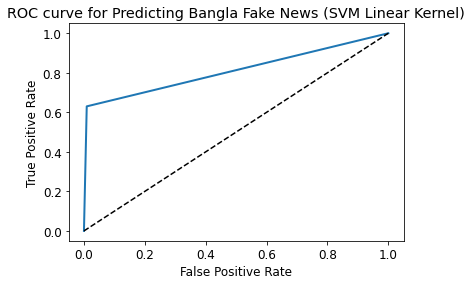

time: 182 ms (started: 2021-09-06 10:38:56 +00:00)


In [19]:
# plot ROC Curve

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, prediction1)

plt.figure(figsize=(6,4))

plt.plot(fpr, tpr, linewidth=2)

plt.plot([0,1], [0,1], 'k--' )

plt.rcParams['font.size'] = 12

plt.title('ROC curve for Predicting Bangla Fake News (SVM Linear Kernel)')

plt.xlabel('False Positive Rate')

plt.ylabel('True Positive Rate')

plt.show()

In [22]:
# compute ROC AUC

from sklearn.metrics import roc_auc_score

ROC_AUC = roc_auc_score(y_test, prediction1)

print('ROC AUC : {:.4f}'.format(ROC_AUC))

ROC AUC : 0.8105
time: 7.68 ms (started: 2021-09-06 11:09:23 +00:00)


In [20]:
# Print the Confusion Matrix and slice it into four pieces

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, prediction1)

print('Confusion matrix\n\n', cm)

print('\nTrue Positives(TP) = ', cm[0,0])

print('\nTrue Negatives(TN) = ', cm[1,1])

print('\nFalse Positives(FP) = ', cm[0,1])

print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[15954   147]
 [  145   247]]

True Positives(TP) =  15954

True Negatives(TN) =  247

False Positives(FP) =  147

False Negatives(FN) =  145
time: 27.3 ms (started: 2021-09-06 10:39:06 +00:00)


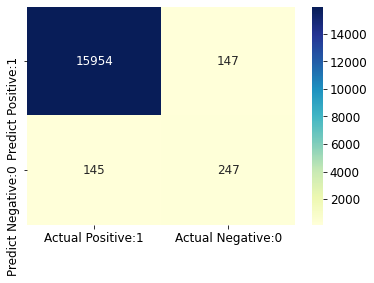

time: 255 ms (started: 2021-09-06 10:39:10 +00:00)


In [21]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [23]:
svc_model1 = SVC(C=1, kernel='poly', gamma= 1)
svc_model1.fit(count_train, y_train)

prediction2 = svc_model1.predict(count_test)

print(classification_report(y_test, prediction2, target_names = ['Fake','True']))

              precision    recall  f1-score   support

        Fake       0.99      0.98      0.98     16101
        True       0.39      0.46      0.42       392

    accuracy                           0.97     16493
   macro avg       0.69      0.72      0.70     16493
weighted avg       0.97      0.97      0.97     16493

time: 11min 23s (started: 2021-09-06 11:12:52 +00:00)


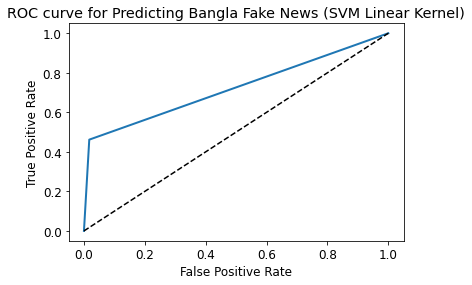

time: 161 ms (started: 2021-09-06 11:24:38 +00:00)


In [24]:
# plot ROC Curve

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, prediction2)

plt.figure(figsize=(6,4))

plt.plot(fpr, tpr, linewidth=2)

plt.plot([0,1], [0,1], 'k--' )

plt.rcParams['font.size'] = 12

plt.title('ROC curve for Predicting Bangla Fake News (SVM Linear Kernel)')

plt.xlabel('False Positive Rate')

plt.ylabel('True Positive Rate')

plt.show()

In [25]:
# compute ROC AUC

from sklearn.metrics import roc_auc_score

ROC_AUC = roc_auc_score(y_test, prediction2)

print('ROC AUC : {:.4f}'.format(ROC_AUC))

ROC AUC : 0.7221
time: 8.51 ms (started: 2021-09-06 11:24:45 +00:00)


In [26]:
# Print the Confusion Matrix and slice it into four pieces

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, prediction2)

print('Confusion matrix\n\n', cm)

print('\nTrue Positives(TP) = ', cm[0,0])

print('\nTrue Negatives(TN) = ', cm[1,1])

print('\nFalse Positives(FP) = ', cm[0,1])

print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[15820   281]
 [  211   181]]

True Positives(TP) =  15820

True Negatives(TN) =  181

False Positives(FP) =  281

False Negatives(FN) =  211
time: 31.3 ms (started: 2021-09-06 11:24:49 +00:00)


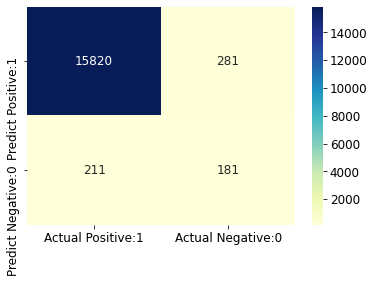

time: 248 ms (started: 2021-09-06 11:24:53 +00:00)


In [27]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [31]:
svc_model1 = SVC(C=1, kernel='rbf', gamma= 1)
svc_model1.fit(count_train, y_train)

prediction3 = svc_model1.predict(count_test)

print(classification_report(y_test, prediction3, target_names = ['Fake','True']))

              precision    recall  f1-score   support

        Fake       0.98      1.00      0.99     16101
        True       1.00      0.02      0.04       392

    accuracy                           0.98     16493
   macro avg       0.99      0.51      0.52     16493
weighted avg       0.98      0.98      0.97     16493

time: 1h 18min 32s (started: 2021-09-06 11:28:53 +00:00)


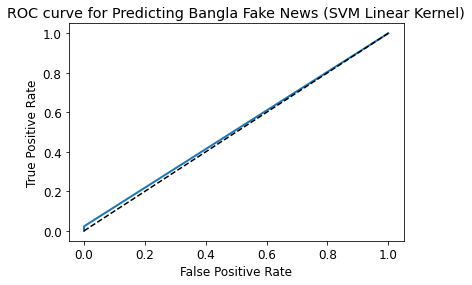

time: 178 ms (started: 2021-09-06 12:47:38 +00:00)


In [32]:
# plot ROC Curve

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, prediction3)

plt.figure(figsize=(6,4))

plt.plot(fpr, tpr, linewidth=2)

plt.plot([0,1], [0,1], 'k--' )

plt.rcParams['font.size'] = 12

plt.title('ROC curve for Predicting Bangla Fake News (SVM Linear Kernel)')

plt.xlabel('False Positive Rate')

plt.ylabel('True Positive Rate')

plt.show()

In [42]:
# compute ROC AUC

from sklearn.metrics import roc_auc_score

ROC_AUC = roc_auc_score(y_test, prediction3)

print('ROC AUC : {:.4f}'.format(ROC_AUC))

ROC AUC : 0.5115
time: 12.6 ms (started: 2021-09-06 12:52:04 +00:00)


In [43]:
# Print the Confusion Matrix and slice it into four pieces

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, prediction3)

print('Confusion matrix\n\n', cm)

print('\nTrue Positives(TP) = ', cm[0,0])

print('\nTrue Negatives(TN) = ', cm[1,1])

print('\nFalse Positives(FP) = ', cm[0,1])

print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[16101     0]
 [  383     9]]

True Positives(TP) =  16101

True Negatives(TN) =  9

False Positives(FP) =  0

False Negatives(FN) =  383
time: 26.7 ms (started: 2021-09-06 12:52:09 +00:00)


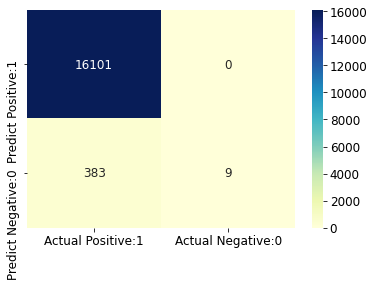

time: 260 ms (started: 2021-09-06 12:52:12 +00:00)


In [44]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [35]:
svc_model1 = SVC(C=1, kernel='sigmoid', gamma= 1)
svc_model1.fit(count_train, y_train)

prediction4 = svc_model1.predict(count_test)

print(classification_report(y_test, prediction4, target_names = ['Fake','True']))

              precision    recall  f1-score   support

        Fake       0.98      0.98      0.98     16101
        True       0.09      0.10      0.09       392

    accuracy                           0.96     16493
   macro avg       0.53      0.54      0.54     16493
weighted avg       0.96      0.96      0.96     16493

time: 1min (started: 2021-09-06 12:48:44 +00:00)


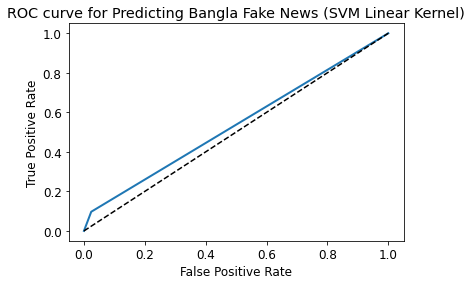

time: 159 ms (started: 2021-09-06 12:50:09 +00:00)


In [38]:
# plot ROC Curve

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, prediction4)

plt.figure(figsize=(6,4))

plt.plot(fpr, tpr, linewidth=2)

plt.plot([0,1], [0,1], 'k--' )

plt.rcParams['font.size'] = 12

plt.title('ROC curve for Predicting Bangla Fake News (SVM Linear Kernel)')

plt.xlabel('False Positive Rate')

plt.ylabel('True Positive Rate')

plt.show()

In [45]:
# compute ROC AUC

from sklearn.metrics import roc_auc_score

ROC_AUC = roc_auc_score(y_test, prediction4)

print('ROC AUC : {:.4f}'.format(ROC_AUC))

ROC AUC : 0.5365
time: 11.5 ms (started: 2021-09-06 12:52:54 +00:00)


In [46]:
# Print the Confusion Matrix and slice it into four pieces

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, prediction4)

print('Confusion matrix\n\n', cm)

print('\nTrue Positives(TP) = ', cm[0,0])

print('\nTrue Negatives(TN) = ', cm[1,1])

print('\nFalse Positives(FP) = ', cm[0,1])

print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[15716   385]
 [  354    38]]

True Positives(TP) =  15716

True Negatives(TN) =  38

False Positives(FP) =  385

False Negatives(FN) =  354
time: 29.8 ms (started: 2021-09-06 12:52:58 +00:00)


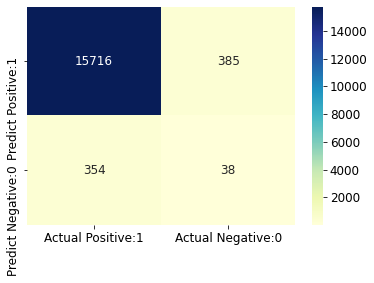

time: 240 ms (started: 2021-09-06 12:53:03 +00:00)


In [47]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')